# Obliczenia hybrydowe

W przypadku obliczeń (kwantowych) `hybrydowe` oznacza strategię mieszania klasycznych i kwantowych obliczeń. 
Idea ta jest podstawowym elementem optymalizacji obwodów wariacyjnych, gdzie kwantowy obwód optymalizowany jest z wykorzystaniem klasycznego ko-procesora.

Najczęściej, obwody (i komputery) kwantowe będziemy wykorzystywać do oszacowania (obliczania) średnich z wyników pomiarów (wartość oczekiwana obserwabli),
które złozyć mozna do pojedynczej klasycznej funkcji kosztu. 
Pozwola nam to oszacować jak dobrze wybrane obwody kwantowe dopasowują się do danych. 
Przykładem moze być model realizowany jako `variational quantum eigensolver` [Peruzzo 2013](https://arxiv.org/abs/1304.3061)

![](../img/vqa.png)


W ogólności łatwo wyobrazić sobie bardziej interesujący sposób w którym mozna łączyć składniki klasyczne i kwantowe w większy i bardziej złozony układ
Kazdy element (czy to kwantowy czy klasyczny) mozna w takim obrazku przedstawić jako klasyczny bądź kwantowy `node`. 

Klasyczne i kwantowe nody mozemy składać w dowolny acykliczny graf (DAG). 
Informacja w takim grafie przebiega w ustalonym kierunku oraz nie występują w nim cykle (pętle). 
 
Jednym z przykładów takiego DAG'a są sieci neuronowe. 

Poniewaz mozemy obliczać gradienty variacyjnych obwodów kwantowych, obliczenia hybrydowe są kompatybilne z algorytmem propagacji wstecznej.
Potwierdza to możliwość trenowania obwodów kwantowych w taki sam sposób w jaki trenuje sie klasyczne sieci neuronowe. 

Korzystając z biblioteki PyTorch możemy generować sieci neuronowe korzystając z modułu `nn`. 
Każdy taki model składa się z elementarnych warstw (ang. _layers_). 
Bilioteka PennyLane pozwala przetworzyć obiekt `QNode` do obiektu `torch.nn`.

W pierwszym kroku stwórzmy dwa zestawy danych. Pierwszy dotyczyć będzie wartości ciągłej, natomiast drugi będzie realizował proces klasyfikacji. 

Dane muszą być przekształcone do obiektu tensora realizowanego w bibliotece torch.

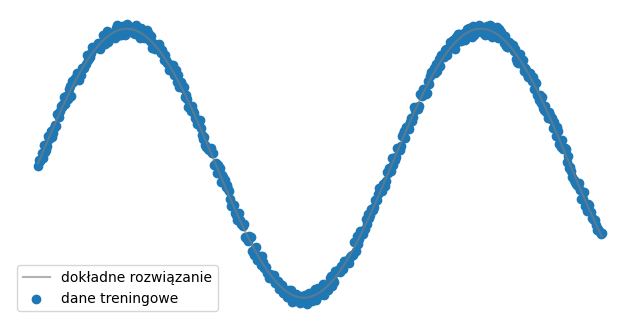

In [1]:
# DANE  dla przewidywania zmiennej ciągłej - funkcja sinus z drobnym szumem
import torch

torch.manual_seed(123)

X_cont = torch.linspace(0,10,500).view(-1,1)
y_cont = torch.sin(X_cont)
y_cont_noise = y_cont + 0.1*(torch.rand(500).view(-1,1)-0.5)

# wyktres danych
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(X_cont, y_cont.view(-1,1), color="tab:grey", alpha=0.6, label="dokładne rozwiązanie")
plt.scatter(X_cont, y_cont_noise, label="dane treningowe")
plt.axis("off")
plt.legend()
plt.show()

Zanim przejdziemy do daleszego etapy zdefiniujmy dodatkowe funkcje przydatne do eksploracji sieci neuronowych.

In [2]:
def mse(y_true, y_pred) -> torch.Tensor:
    return torch.mean((y_true - y_pred)**2)

def train(X, Y, model, optimiser, iteration, lossfn, callback = None):
    """ Dodatkowa funkcja pozwalająca wykonać trenowanie naszej sieci neuronowej"""
    for i in range(iteration):
        optimiser.zero_grad()
        prediction = model(X)
        loss = lossfn(Y, prediction)
        loss.backward()
        optimiser.step()
        if callback is not None: 
            callback(model, loss)

losses = []

def callback(model, loss):
    losses.append(loss.item())
    x = torch.linspace(0,10,500).view(-1,1)
    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="QML solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()

W następnym kroku zdefiniujmy obiekt realizujący obwód kwantowy: QNode, który chcemy podpiąć pod `torch.nn`. 
Dla uproszczenia sytuacji przyjmiemy obwód wykorzystujący 2 kubity.



In [3]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)
# NASZ kwantowy PQC - parametryzowany obwód kwantowy dla jednej warstwy ukrytej
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

Obwód ten pobiera dane wejściowe i przetwarza je za pomocą zdefiniowanego obwodu kodującego dane `Angle Embedding`. 
Następnie wynik tej operacji,czyli dane zanurzone do przestrzeni Hilberta stanów, są przetwarzane (obracane przez parametryczne bramki z wagami) jest przez `ansatz` (model kwantowy) z wykorzystaniem gotowego obwodu realizowanego jako `BasicENtanglerLayers`.

Całość można zrozumieć jako jedna wartwa `nn.Linear`. 

Biblioteka PennyLane udostępnia obiekt `TorchLayer`, który pozwala na taką transformację. 
Zanim jednak go użyjemy musimy utworzyć słownik z wagami. 


In [4]:
n_layers = 5

weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [5]:
class QN(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, n_input: int, n_output: int, quanutm_layer):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_input, n_qubits),
            quanutm_layer,
            torch.nn.Linear(n_qubits, n_output)
        )
        

    def forward(self, x):
        return  self.layers(x)

Dla przypadku estymacji funkcji sinus mamy jedną zmienną (`x_cont`) wejściową która zostanie połączona z dwoma kubitami następnie na wyjściu mamy również jedną zmienną (`y_cont`).

In [6]:
reg_qmodel = QN(1, 1, qlayer)
print(reg_qmodel)

QN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): <Quantum Torch Layer: func=qnode>
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)


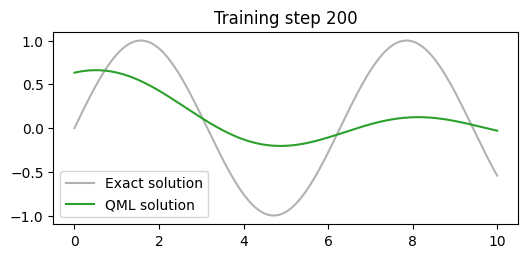

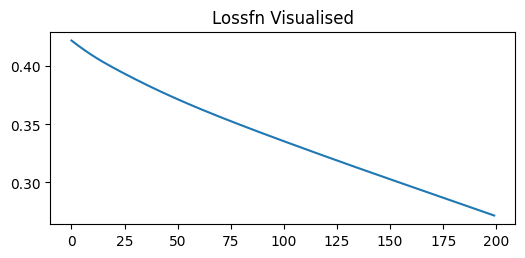

In [7]:
from IPython.display import clear_output 

learning_rate=1e-3
optimiser = torch.optim.Adam(reg_qmodel.parameters(), lr=learning_rate)

train(X_cont, y_cont_noise, reg_qmodel, optimiser, 200, mse, callback)

In [8]:

batches = torch.utils.data.DataLoader(
    list(zip(X_cont, y_cont_noise)), batch_size=10, shuffle=True, drop_last=True
)

In [9]:
def train_batch(data_loader, model, optimiser, iteration, lossfn, callback = None):
    """ Dodatkowa funkcja pozwalająca wykonać trenowanie naszej sieci neuronowej"""
    for i in range(iteration):
        for X, Y in data_loader:
            optimiser.zero_grad()
            prediction = model(X)
            loss = lossfn(Y, prediction)
            loss.backward()
            optimiser.step()
            if callback is not None: 
                callback(model, loss)

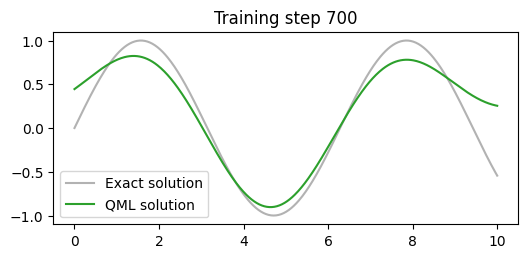

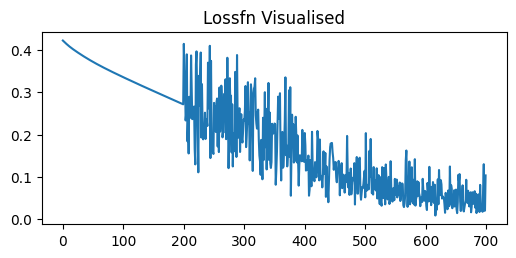

In [10]:
train_batch(batches, reg_qmodel, optimiser, 10, mse, callback)

## Klasyfikacja z wykorzystaniem kwantowej sieci neuronowej 

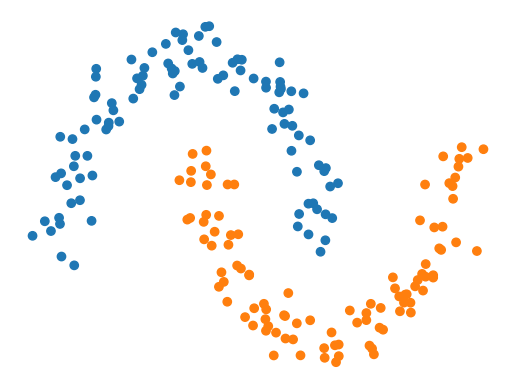

In [11]:
import torch
import pennylane.numpy as np
from sklearn.datasets import make_moons

torch.manual_seed(123)


X, y = make_moons(n_samples=200, noise=0.1)

# create torch

X = torch.from_numpy(X).to(torch.float32)

y_ = torch.from_numpy(y).view(-1,1)


c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # kolorowanie
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()


y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1).to(torch.float32)

# X = X.clone().detach().requires_grad_(True)

![](../img/model1.png)

In [12]:
class QN2(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, quanutm_layer):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
            quanutm_layer,
            torch.nn.Linear(2, 2),
            torch.nn.Softmax(dim=1)
        )
        

    def forward(self, x):
        return  self.layers(x)

In [13]:
qclassifier = QN2(qlayer)
print(qclassifier)

QN2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): <Quantum Torch Layer: func=qnode>
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)


In [14]:
opt = torch.optim.SGD(qclassifier.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [15]:
batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(qclassifier(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = qclassifier(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.4803
Average loss over epoch 2: 0.3293
Average loss over epoch 3: 0.2266
Average loss over epoch 4: 0.1889
Average loss over epoch 5: 0.1809
Average loss over epoch 6: 0.1726
Accuracy: 86.5%


![](../img/model2.png)

In [16]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.4345
Average loss over epoch 2: 0.2538
Average loss over epoch 3: 0.1893
Average loss over epoch 4: 0.1633
Average loss over epoch 5: 0.1664
Average loss over epoch 6: 0.1548
Accuracy: 87.0%
